<!-- <img src="./logo_UTN.svg" align="right" width="150" />  -->
<img src="Logo_UNSAM.png" align="right" width="150" />  -->
#### Análisis y Procesamiento Digital de Señales

# Tarea Semanal N°07
#### Montserrat Coto



## Introducción



El análisis de señales electrocardiográficas (ECG) requiere técnicas de procesamiento digital que permitan eliminar interferencias sin comprometer la integridad morfológica de la señal. En esta tarea se parte del archivo ecg.mat, que contiene un registro de ECG real adquirido durante una prueba de esfuerzo, con una frecuencia de muestreo de *1 kHz* y acompañado por variables de referencia como localización de latidos *(qrs_detections)* y plantillas promedio de latidos normales y ventriculares.

El objetivo principal es diseñar y aplicar filtros digitales que permitan mitigar tres fuentes típicas de contaminación:

- Ruido muscular y por movimiento de electrodos (ambos en alta frecuencia).

- Movimiento de la línea de base causado por la respiración (baja frecuencia).

Para ello, se estableció una plantilla de diseño basada en el ancho de banda estimado del ECG (según lo trabajado en la Tarea Semanal 5) y se tomaron como referencia morfologías promedio provistas (heartbeat_pattern1, heartbeat_pattern2 y qrs_pattern1) para evaluar la efectividad de los filtros en cuanto a suavidad y nivel isoeléctrico.

Se diseñaron al menos dos filtros IIR (Butterworth y Cauer, aproximaciones de máxima planicidad y de mínima banda de transición, respectivamente) y dos FIR (uno con ventana de Kaiser y otro por mínimos cuadrados), todos implementados con funciones de scipy.signal.

Finalmente, se analizó su desempeño desde múltiples perspectivas:

- La respuesta en frecuencia de cada filtro y su adecuación a la plantilla deseada.

- La atenuación de señales interferentes (alta o baja frecuencia).

- La preservación de la señal útil en zonas sin contaminación, evaluando qué tan inocuo es el filtrado.

- El impacto en la morfología de los latidos, especialmente en la forma del complejo QRS y la línea de base.

Esta tarea busca no sólo cumplir con los requisitos técnicos de la consigna, sino también reflexionar sobre las limitaciones prácticas del diseño de filtros digitales en contextos reales, evaluando cómo se comportan frente a señales fisiológicas complejas y con diferentes tipos de ruido presentes.

# Desarollo

##### Definición de Parámetros

In [72]:
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla
from scipy.signal import sosfreqz, group_delay
from pytc2.filtros_digitales import fir_design_ls

plt.close('all')

##################
#%% Lectura de ECG #
##################

fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
nyq_frec = fs_ecg / 2  # Frecuencia de Nyquist

# Variables del archivo mat_struct
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
heartbeat_normal = mat_struct['heartbeat_pattern1'].flatten()
heartbeat_ventricular = mat_struct['heartbeat_pattern2'].flatten()
qrs_locations = mat_struct['qrs_detections'].flatten()

ecg_one_lead = ecg_one_lead / np.std(ecg_one_lead)
heartbeat_normal = heartbeat_normal / np.std(heartbeat_normal)
heartbeat_ventricular = heartbeat_ventricular / np.std(heartbeat_ventricular)
qrs_pattern = qrs_pattern /np.std(qrs_pattern)



ModuleNotFoundError: No module named 'pytc2.filtros_digitales'

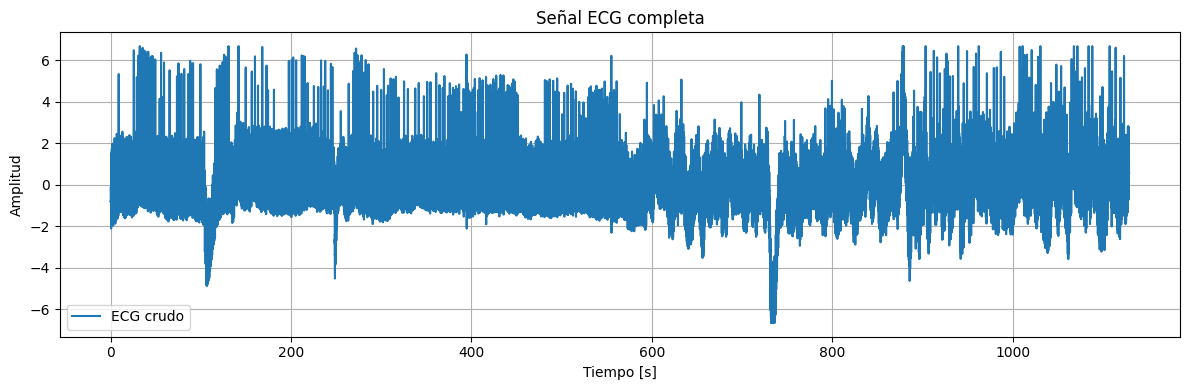

In [73]:
#%% Visualización señal completa

plt.figure(figsize=(12, 4))
t_total = np.arange(len(ecg_one_lead)) / fs_ecg
plt.plot(t_total, ecg_one_lead, label='ECG crudo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Señal ECG completa')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

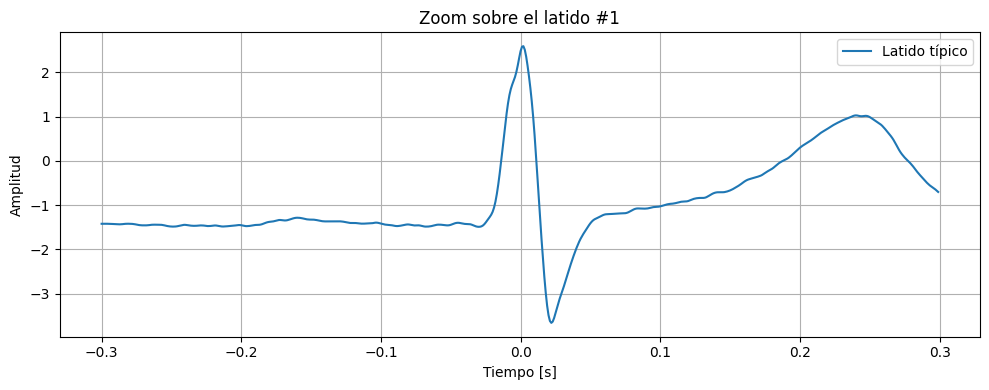

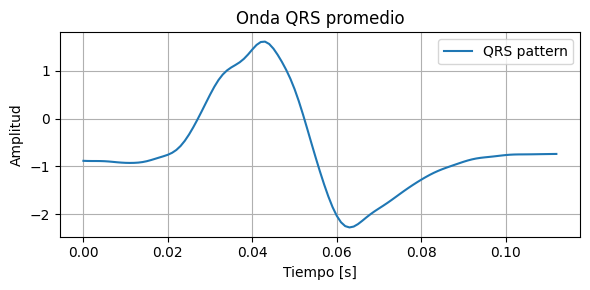

In [57]:
#%% Visualización latido típico

i = 0
sample_center = int(qrs_locations[i])
window_size = 0.6  # segundos (±300 ms)
N = int(window_size * fs_ecg)

ecg_segment = ecg_one_lead[sample_center - N // 2 : sample_center + N // 2]
ecg_segment = ecg_segment / np.std(ecg_segment)
t_segment = np.arange(-N//2, N//2) / fs_ecg

plt.figure(figsize=(10, 4))
plt.plot(t_segment, ecg_segment, label='Latido típico')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title(f'Zoom sobre el latido #{i + 1}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#%% Visualización QRS


plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(qrs_pattern)) / fs_ecg, qrs_pattern, label='QRS pattern')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Onda QRS promedio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Visualización del latido típico:**  
Este gráfico permite identificar con la duración y forma general del latido, especialmente del complejo QRS, así como las ondas P y T que lo rodean. Esta información es útil para definir las bandas de frecuencia que debe preservar el filtro y evitar distorsionar las componentes clave del ECG.

**Latido promedio normal y ventricular:**  
Al comparar el latido promedio de ritmos normales y ventriculares, se observan diferencias en morfología y duración que pueden influir en la selección del ancho de banda del filtro, ya que el filtro debe ser lo suficientemente flexible para preservar las características de ambos tipos.

**Onda QRS promedio:**  
Muestra la duración típica, lo que ayuda a determinar la frecuencia máxima relevante que el filtro debe mantener. Esto es crucial para diseñar un filtro que permita la detección precisa del QRS sin atenuar sus componentes importantes ni introducir retrasos significativos.


## 1. Filtro IIR

### A y B) Plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG

### b) Establecimiento de la plantilla de diseño para filtros digitales

Se diseñaron dos filtros digitales pasabanda IIR utilizando la aproximación de Butterworth (máxima planicidad) y Cauer mediante la función `iirdesign` de SciPy. 

Para el diseño de la plantilla, se eligieron:

- **Frecuencias de paso entre 0.5 Hz y 30 Hz**:  
  El límite inferior de 0.5 Hz permite preservar el contenido útil del ECG, mientras se eliminan componentes de muy baja frecuencia, como el desplazamiento de línea base causado por movimientos respiratorios o el desplazamiento de electrodos.  
  El límite superior de 30 Hz se definió a partir del análisis espectral realizado en la TS05, donde se observó que el 98% de la energía estaba por debajo de 27.5 Hz. Se agregó un pequeño margen para asegurar la conservación de componentes de interés.

- **Bandas de detención por debajo de 0.1 Hz y por encima de 50 Hz**:  
  La banda de rechazo inferior (< 0.1 Hz) garantiza la eliminación efectiva de variaciones lentas no fisiológicas.  
  La banda de rechazo superior (> 50 Hz) busca filtrar el ruido de la red eléctricaa. Además, las frecuencias por encima de 50 Hz no aportan información relevante sobre los latidos y solo introducen ruido de alta frecuencia.

- **Rizado máximo en banda de paso (α_max): 0.5 dB**  
  Se permite un rizado de hasta 0.5 dB en la banda de paso, lo cual representa una pequeña variación de ganancia que no afecta significativamente la morfología de los latidos. 

- **Atenuación mínima en banda de detención (α_min): 40 dB**  
  Se requiere una atenuación de al menos 40 dB para asegurar que las componentes fuera de banda se reduzcan lo suficiente.  
  Este valor equivale a una atenuación de 100 veces en amplitud, lo que corresponde a una década, es decir, una reducción de un orden de magnitud.

A continuación, se presenta la plantilla de diseño junto con la respuesta en frecuencia del filtro.  
Se utiliza una grilla de frecuencias con mayor resolución entre 0.5 Hz y 1.2 Hz para observar más claramente la transición en bajas frecuencias, región crítica para asegurar la eliminación del desplazamiento de línea base sin afectar los primeros armónicos del ECG.


### ----------- Aproximación de máxima planicidad (Butterworth) -----------

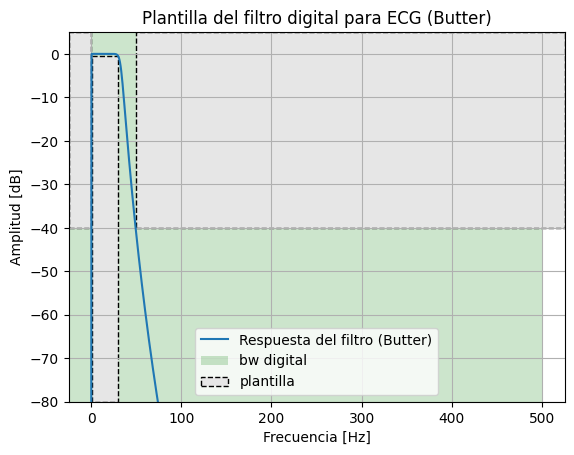

In [64]:

filter_type = 'bandpass'


# # ----------- Aproximación de máxima planicidad (Butterworth) -----------
# # Descomentar esta línea para usar Butterworth (máxima planicidad)
aprox_name = 'butter'
mi_sos_butter = sig.iirdesign(
    wp=[0.5, 30],
    ws=[0.1, 50],
    gpass=0.5,
    gstop=40,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)
fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.1, 50])      # Banda de detención
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)


# Diseño del filtro (estructura en SOS)
mi_sos_butter = sig.iirdesign(
    wp=fpass,
    ws=fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)


ecg_filtrada_butter = sig.sosfiltfilt(mi_sos_butter, ecg_segment)
ecg_filtrada_butter = ecg_filtrada_butter / np.std(ecg_filtrada_butter)

#%% Visualización de plantilla y respuesta en frecuencia

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(mi_sos_butter, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro (Butter)')
plt.title(f'Plantilla del filtro digital para ECG (Butter)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type=filter_type,
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()




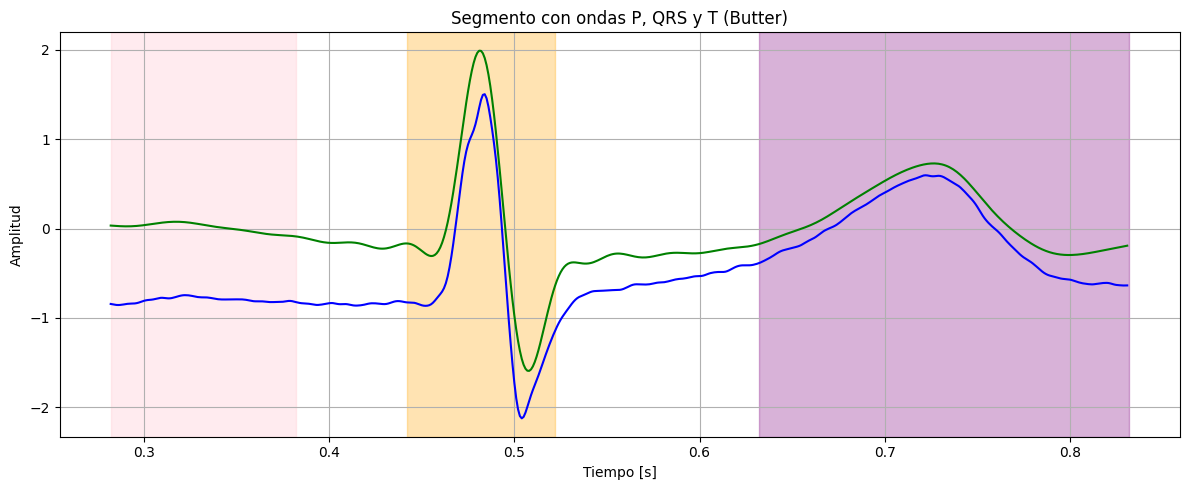

In [61]:


#%% Visualización segmento con ondas P, QRS y T

# Parámetros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms después del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms después del QRS (inicio T)
t_end_sec = 0.35      # 350 ms después del QRS (fin T)

# Muestras relativas
sample_center = int(qrs_locations[0])
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos un segmento amplio para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg
ecg_filtrada_butter_full = sig.sosfiltfilt(mi_sos_butter, ecg_segment_full)

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_butter_full, label='ECG Filtrada', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Butter)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.tight_layout()
plt.show()

En este gráfico se intentó identificar el segmento que contiene las ondas P, QRS y T. Este método no detecta automáticamente las ondas P y T, sino que utiliza posiciones estimadas basadas en tiempos y duraciones fisiológicas promedio.

Partiendo de `qrs_locations[0]`, que indica el índice en el vector temporal donde ocurre el complejo QRS, se consideraron las siguientes aproximaciones: la onda P comienza aproximadamente 0.1 segundos antes del QRS y tiene una duración típica entre 0.08 y 0.1 segundos; el complejo QRS se encuentra centrado en la posición del QRS y su duración habitual está entre 0.08 y 0.12 segundos; finalmente, la onda T inicia alrededor de 0.2 segundos después del QRS y dura típicamente entre 0.16 y 0.2 segundos.

Estas estimaciones permiten visualizar cada onda con un margen suficiente para observar su forma, aunque no sustituyen una detección automática precisa.


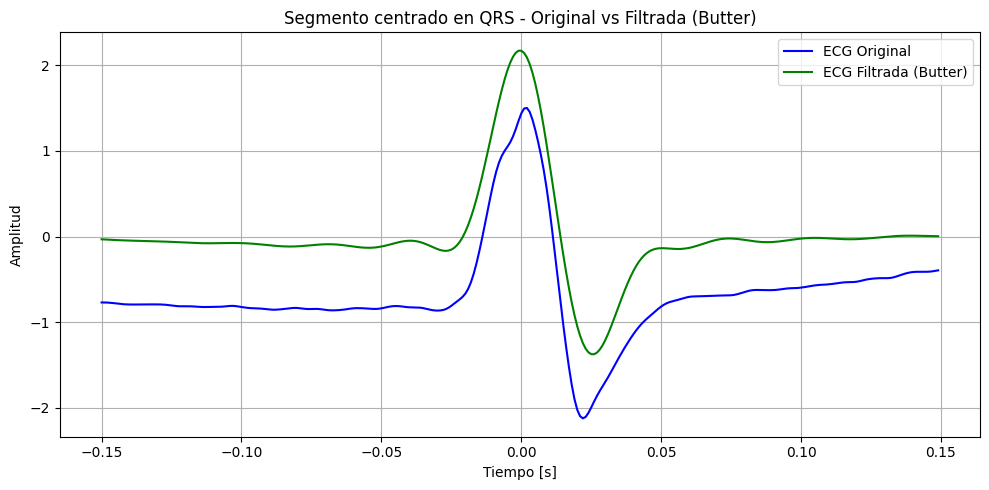

In [65]:
#%% Aplicación del filtro justo sobre el QRS

# Centrado en el mismo latido de antes
i = 0
sample_center = int(qrs_locations[i])

# Nueva ventana más ajustada: ±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Extracción del segmento centrado en el QRS
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Filtrado
ecg_filtrada_butter_qrs = sig.sosfiltfilt(mi_sos_butter, ecg_segment_qrs)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(t_qrs, ecg_segment_qrs, label='ECG Original', color='blue')
plt.plot(t_qrs, ecg_filtrada_butter_qrs, label=f'ECG Filtrada (Butter)', color='green')
plt.title(f'Segmento centrado en QRS - Original vs Filtrada (Butter)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


La ventana de 0.2 segundos se centró en la posición indicada por *qrs_location*, que marca el instante del complejo QRS detectado en la señal ECG. Esta región representa la despolarización ventricular y es la porción más energética y característica del latido cardíaco, por lo que centrar el análisis allí permite evaluar con mayor claridad el efecto del filtrado sobre la morfología del pulso.
Desde el punto de vista biológico, el complejo QRS tiene una duración típica de entre 0.06 y 0.10 segundos, siendo patológico si supera los 0.12 segundos. Por eso, una ventana de 0.2 s permite capturar completamente el QRS, junto con un pequeño margen antes y después, proporcionando contexto temporal suficiente para observar su forma completa y las posibles distorsiones introducidas por el filtro.

### ----------- Aproximación Cauer -----------

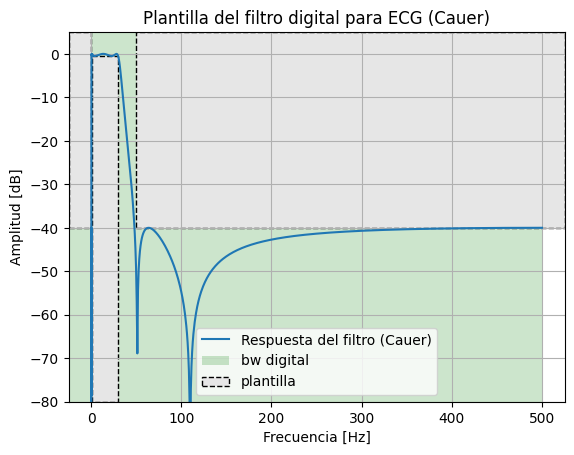

In [66]:
# ----------- Aproximación de Cauer (Elíptico) -----------
# Descomentar esta línea para usar Elíptico (Cauer, mínima orden)
aprox_name = 'ellip'
mi_sos_ellip = sig.iirdesign(
    wp=[0.5, 30],
    ws=[0.1, 50],
    gpass=0.5,
    gstop=40,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)

fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.1, 50])      # Banda de detención
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)

# Diseño del filtro (estructura en SOS)
mi_sos_ellip = sig.iirdesign(
    wp=fpass,
    ws=fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)


ecg_filtrada_ellip = sig.sosfiltfilt(mi_sos_ellip, ecg_segment)
ecg_filtrada_ellip = ecg_filtrada_ellip / np.std(ecg_filtrada_ellip)

#%% Visualización de plantilla y respuesta en frecuencia

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(mi_sos_ellip, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro (Cauer)')
plt.title(f'Plantilla del filtro digital para ECG (Cauer)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type=filter_type,
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()


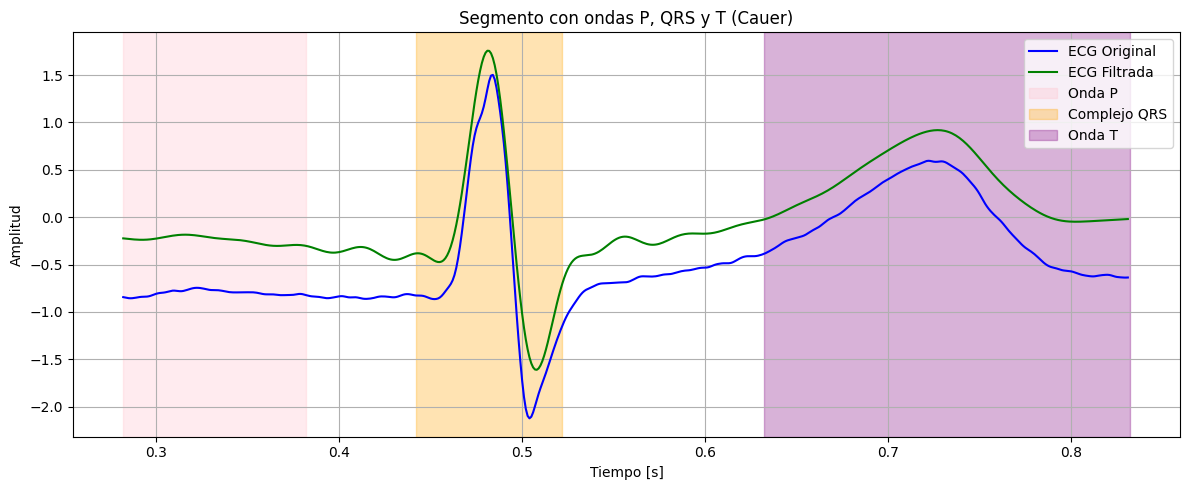

In [67]:
#%% Visualización segmento con ondas P, QRS y T

# Parámetros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms después del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms después del QRS (inicio T)
t_end_sec = 0.35      # 350 ms después del QRS (fin T)

# Muestras relativas
sample_center = int(qrs_locations[0])
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos un segmento amplio para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg
ecg_filtrada_ellip_full = sig.sosfiltfilt(mi_sos_ellip, ecg_segment_full)

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_ellip_full, label='ECG Filtrada', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Cauer)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


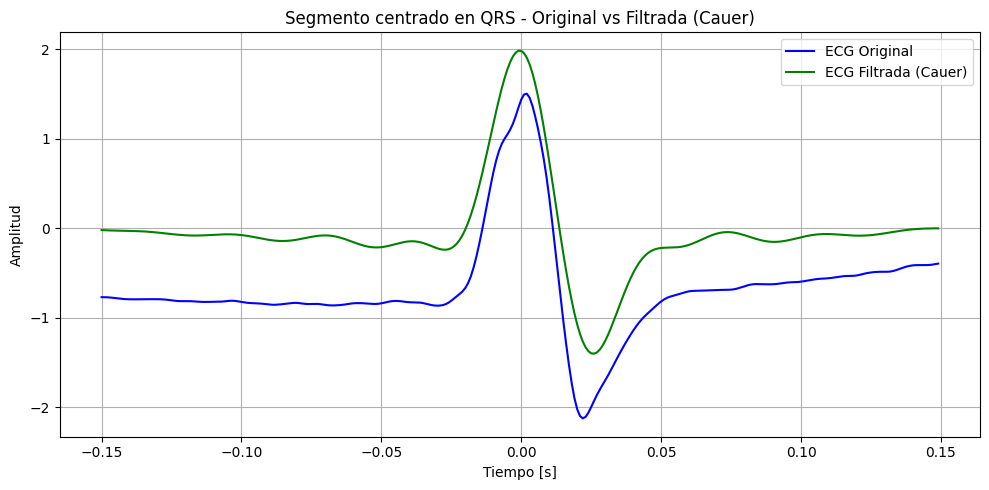

In [68]:
#%% Aplicación del filtro justo sobre el QRS

# Centrado en el mismo latido de antes
i = 0
sample_center = int(qrs_locations[i])

# Nueva ventana más ajustada: ±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Extracción del segmento centrado en el QRS
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Filtrado
ecg_filtrada_ellip_qrs = sig.sosfiltfilt(mi_sos_ellip, ecg_segment_qrs)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(t_qrs, ecg_segment_qrs, label='ECG Original', color='blue')
plt.plot(t_qrs, ecg_filtrada_ellip_qrs, label=f'ECG Filtrada (Cauer)', color='green')
plt.title(f'Segmento centrado en QRS - Original vs Filtrada (Cauer)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 2. Filtro FIR

## b) Establecimiento de la plantilla de diseño para filtros digitales FIR

Para el diseño del filtro FIR pasabanda se consideraron las diferencias clave frente a los filtros IIR. En particular, los filtros FIR suelen tener coeficientes simétricos, lo que les garantiza una **respuesta lineal en fase**. Sin embargo, esta característica limita la flexibilidad en la configuración de la plantilla, especialmente en términos de transiciones abruptas y selectividad, requiriendo un mayor número de coeficientes (orden más alto) para lograr especificaciones similares a las de un filtro IIR.

Por esta razón, para el filtro FIR se decidió ser más flexible en la definición de la banda de paso y las transiciones, buscando un **balance entre la complejidad computacional y la calidad del filtrado**.

Se establecieron las siguientes especificaciones para el diseño con ventana Kaiser:

- **Banda de paso desde 1 Hz hasta 35 Hz:**  
  Esta banda se seleccionó para preservar los componentes relevantes de la señal ECG, como las ondas P y T, mientras se atenúan interferencias fuera del rango fisiológico. Se permite una ligera pérdida por debajo de 1 Hz para facilitar la transición suave propia de filtros FIR.

- **Bandas de rechazo por debajo de 0.1 Hz y por encima de 50 Hz:**  
  Las bandas de detención tienen atenuación desde 0 hasta 0.1 Hz en el rango inferior y desde 50 Hz hasta la frecuencia de Nyquist, con una atenuación objetivo de 40 dB. Se optó por transiciones menos abruptas para mantener un orden de filtro computacionalmente viable.

- **Orden del filtro: 2000 (2001 coeficientes):**  
  Se eligió este orden alto para asegurar la selectividad requerida, aceptando la mayor complejidad computacional a cambio de una buena conservación de la morfología de la señal ECG.

- **Ventana Kaiser con beta = 6:**  
  Se utilizó esta ventana para suavizar el diseño del filtro y lograr un buen compromiso entre el ancho de las bandas de transición y la atenuación en las zonas de stopband

Además, para un diseño alternativo con mínimos cuadrados (Least Squares), se definieron estas especificaciones:

- **Banda de paso desde 2 Hz hasta 35 Hz** y bandas de detención desde 0 a 0.5 Hz y desde 50 Hz hasta Nyquist.

- **Rizado permitido en banda de paso de 2 dB y atenuación en bandas de detención de 30 dB.**

- **Orden del filtro: 207 coeficientes**, buscando un compromiso entre calidad y eficiencia computacional.

Esta configuración implica un compromiso: la atenuación en frecuencias menores a 1 Hz no es tan estricta como en el filtro IIR, pero se prioriza la **conservación de la morfología** de la señal ECG, minimizando distorsiones en las ondas de interés.

A continuación, se presenta la plantilla de diseño junto con la respuesta en frecuencia de ambos filtros FIR, en las cuales se observa una transición más gradual en la banda inferior y la preservación de las características importantes del ECG.


### ----------- Método por ventanas (Kaiser) -----------

.

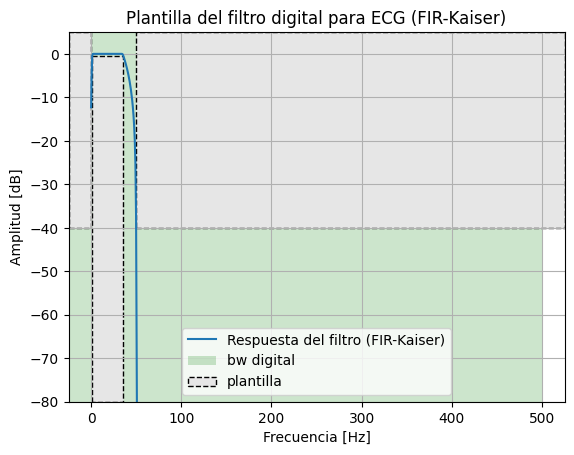

In [69]:
#%% Diseño de filtros con FIR - Ventanas

# Parámetros de la plantilla del filtro 
fpass = np.array([1.3, 35])      # Banda de paso
fs_ecgtop = np.array([0.1, 50])  # Banda de detención
ripple = 0.5                    # Rizado en banda de paso (dB)
attenuation = 40                # Atenuación en banda de detención (dB)

#%% Diseño de filtro con firwin2

cant_coef = 2001    # cantidad de coeficientes (orden + 1), ideal impar

nyq = fs_ecg / 2        # frecuencia de Nyquist

# Definimos los puntos de frecuencia y ganancia
#freq_hz = [0.0, 0.5, 1, 40.0, 50.0, nyq] 
freq_hz =[0.0, 0.1, 1, 35.0, 50.0, nyq]  # en Hz
gain =    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]   # ganancia deseada en cada punto

# Normalizar las frecuencias
freq_norm = [f / nyq for f in freq_hz]

# Diseñar el filtro con firwin2
Windows_fir = sig.firwin2(
    numtaps=cant_coef,
    freq=freq_norm,
    gain=gain,
    window=('kaiser', 6)
)

aprox_name = 'FIR-Kaiser' 

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sig.freqz(Windows_fir, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro ({aprox_name})')
plt.title(f'Plantilla del filtro digital para ECG ({aprox_name})')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fs_ecgtop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()


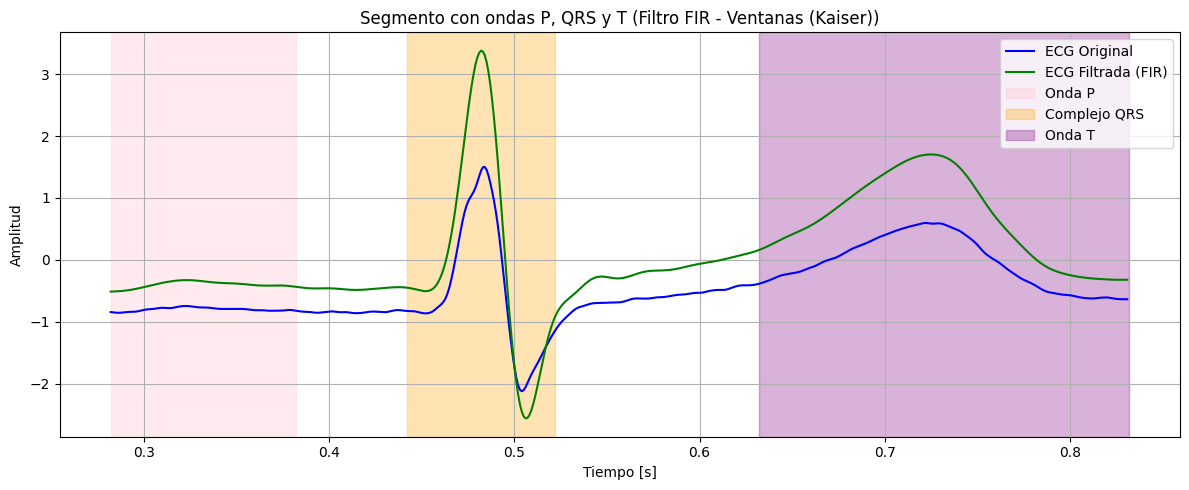

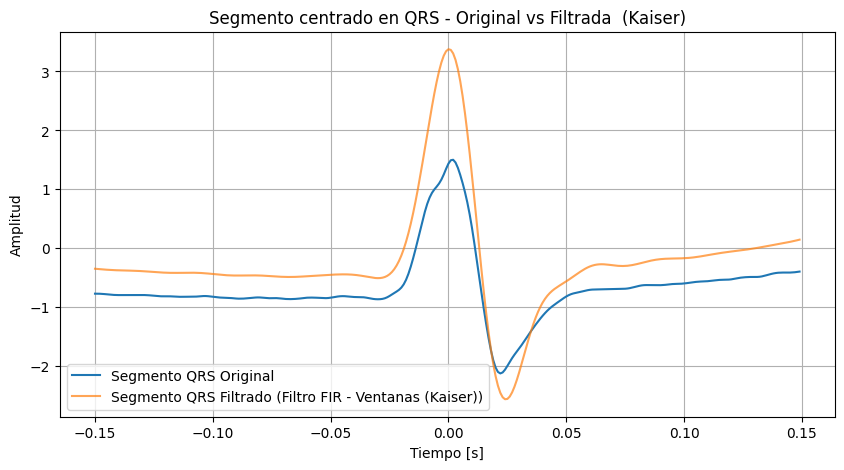

In [70]:
#%% Aplicación de filtros

# Filtramos la señal
ecg_filtrado_kaiser = sig.lfilter(Windows_fir, 1, ecg_one_lead)
t = np.arange(len(ecg_one_lead)) /fs_ecg


# Aplicación de filtros sin retardo con filtfilt
ecg_filtrado_kaiser = sig.filtfilt(Windows_fir, [1], ecg_one_lead)
ecg_filtrado_kaiser=ecg_filtrado_kaiser/np.std(ecg_filtrado_kaiser)

#%% Comparativa señales originales vs filtradas: FIR Kaiser
# Visualización segmento con ondas P, QRS y T usando filtro FIR

# Parámetros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms después del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms después del QRS (inicio T)
t_end_sec = 0.35      # 350 ms después del QRS (fin T)

# Ubicación del primer QRS
sample_center = int(qrs_locations[0])

# Cálculo de índices en muestras
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos segmento completo para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg

# Aplicar filtro FIR con lfilter
ecg_filtrada_full = ecg_filtrado_kaiser[start_segment:end_segment]

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_full, label='ECG Filtrada (FIR)', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Filtro FIR - Ventanas (Kaiser))')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# QRS
# Índice del latido a analizar
i = 0
sample_center = int(qrs_locations[i])

# Ventana centrada ±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Segmento QRS original (sin filtrar)
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Segmento QRS filtrado, extraído de la señal filtrada completa
ecg_segment_qrs_filt = ecg_filtrado_kaiser[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Tiempo para la ventana QRS
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Graficar ambos
plt.figure(figsize=(10,5))
plt.plot(t_qrs, ecg_segment_qrs, label='Segmento QRS Original')
plt.plot(t_qrs, ecg_segment_qrs_filt, label='Segmento QRS Filtrado (Filtro FIR - Ventanas (Kaiser))', alpha=0.7)
plt.title('Segmento centrado en QRS - Original vs Filtrada  (Kaiser)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

### ----------- Cuadrados Mínimos -----------

Como en este entorno no me es posible ejecutar la función `fir_design_ls` de la librería `pytc2.filtros_digitales`, incluyo a continuación las imágenes del filtro por mínimos cuadrados (LS) que obtuve al correr el código localmente.  
De todas maneras, dejo el código disponible por si el docente desea ejecutarlo en su propia máquina.


In [29]:
#%% Diseño de FIR con cuadrados mínimos

# Parámetros

fs_ecgtop = np.array([0.5, 50])    # Banda de detención
fpass = np.array([2, 35])          # Banda de paso
ripple = 2                        # dB (banda de paso)
attenuation = 30                  # dB (banda de detención)

# Frecuencias normalizadas (por Nyquist = fs_ecg/2)
fn = fs_ecg / 2
Be = [
    0.0, fs_ecgtop[0]/fn,           # detención baja
    fpass[0]/fn, fpass[1]/fn,       # paso
    fs_ecgtop[1]/fn, 1.0            # detención alta
]

# Respuesta deseada en cada banda
D = [0, 0, 1, 1, 0, 0]

# Peso relativo (convertido de dB aproximado)
W = [10**(attenuation/20), 1, 10**(attenuation/20)]  # enfatiza la banda de paso

# Estimamos orden (puedes refinar esto)
N = 207 # orden del filtro (ajustable)

# Diseño del filtro
lsq_fir = fir_design_ls(order=N, band_edges=Be, desired=D, weight=W, filter_type='m', grid_density=16)

# Evaluamos FFT
fft_sz = 4096
H = np.fft.fft(lsq_fir, fft_sz)
frecuencias = np.linspace(0, fn, fft_sz//2)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(frecuencias, 20*np.log10(np.abs(H[:fft_sz//2]) + 1e-8), label='Filtro FIR LS')
plt.title("Respuesta en Frecuencia del Filtro FIR Pasabanda")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True)
plt.legend()
plt.tight_layout()

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fs_ecgtop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.title(f"Filtro FIR Pasa Banda - Orden {N}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'fir_design_ls' is not defined

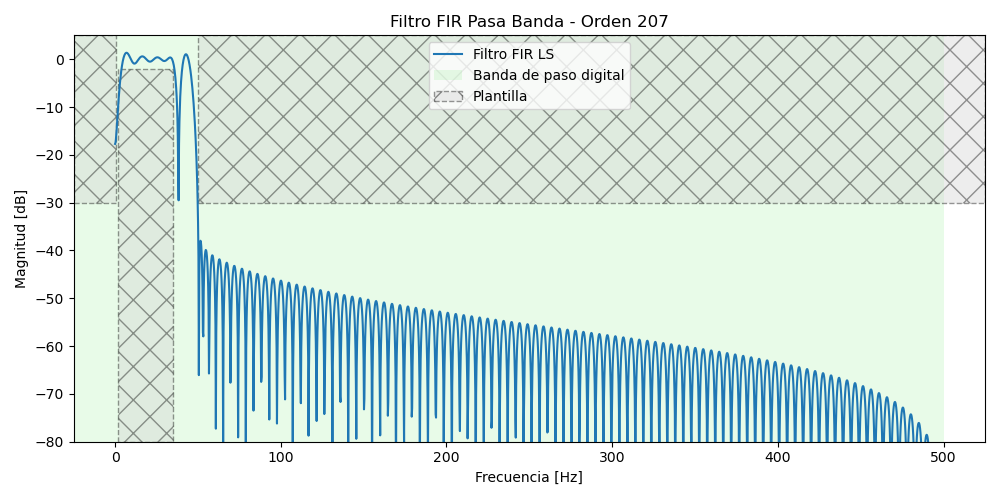

In [4]:
from IPython.display import Image
Image("Plantilla LS.PNG", width=1000, height=600)

In [40]:
#%% Aplicación de filtros

# Filtramos la señal 

ecg_filtrado_ls = sig.lfilter(lsq_fir, 1, ecg_one_lead)
t = np.arange(len(ecg_one_lead)) /fs_ecg

ecg_filtrado_ls = sig.filtfilt(lsq_fir, [1], ecg_one_lead)
ecg_filtrado_ls=ecg_filtrado_ls/np.std(ecg_filtrado_ls)

#%% Comparativa señales originales vs filtradas: FIR LSQ
#%% Visualización segmento con ondas P, QRS y T usando filtro FIR LSQ

# Parámetros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms después del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms después del QRS (inicio T)
t_end_sec = 0.35      # 350 ms después del QRS (fin T)

# Ubicación del primer QRS
sample_center = int(qrs_locations[0])

# Cálculo de índices en muestras
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos segmento completo para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg

# Aplicar filtro FIR con lfilter (ya calculado anteriormente)
ecg_filtrada_full_ls = ecg_filtrado_ls[start_segment:end_segment]

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_full_ls, label='ECG Filtrada (FIR LSQ)', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Filtro FIR - Cuadrados Mínimos)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#%% QRS
# Índice del latido a analizar
i = 0
sample_center = int(qrs_locations[i])

# Ventana centrada ±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Segmento QRS original (sin filtrar)
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Segmento QRS filtrado, extraído de la señal filtrada completa (LSQ)
ecg_segment_qrs_filt = ecg_filtrado_ls[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Tiempo para la ventana QRS
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Graficar ambos
plt.figure(figsize=(10,5))
plt.plot(t_qrs, ecg_segment_qrs, label='Segmento QRS Original')
plt.plot(t_qrs, ecg_segment_qrs_filt, label='Segmento QRS Filtrado (Filtro FIR - Cuadrados Mínimos)', alpha=0.7)
plt.title(f'Segmento QRS Filtrado (Filtro FIR - Ventanas (Cuadrados Mínimos))')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'lsq_fir' is not defined

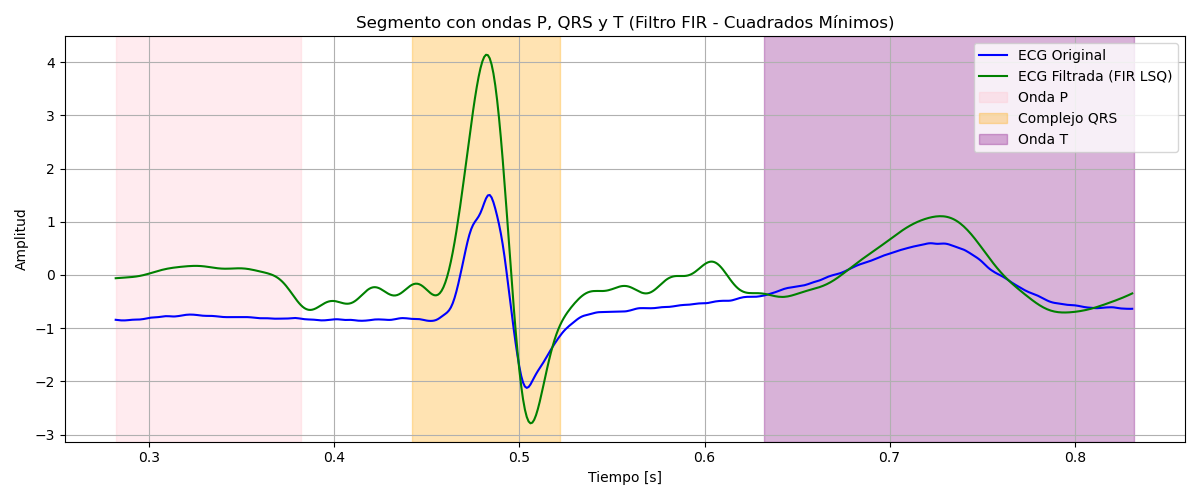

In [3]:
from IPython.display import Image
Image("P, QRS T LS.PNG", width=1000, height=600)

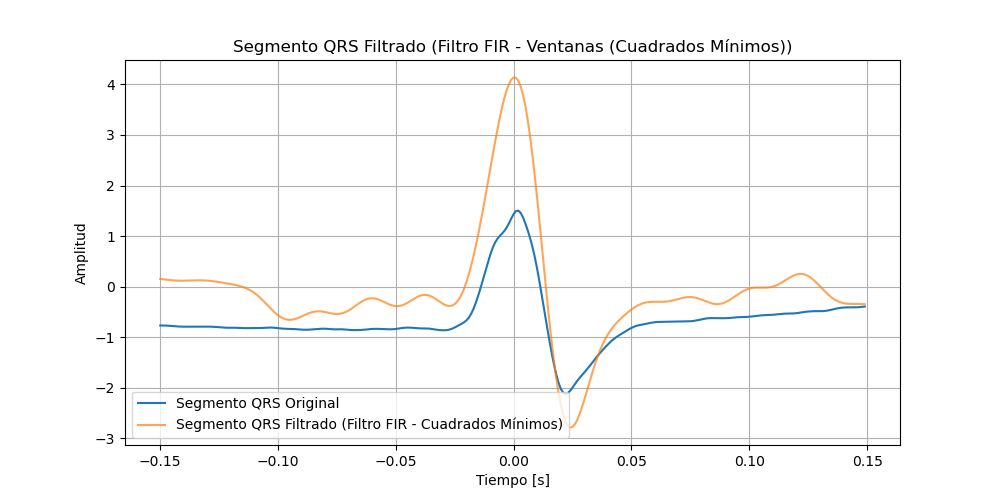

In [5]:
from IPython.display import Image
Image("QRS LS.PNG", width=1000, height=600)

### D) Evaluación del rendimiento de los filtros

NameError: name 'ecg_filtrado_ls' is not defined

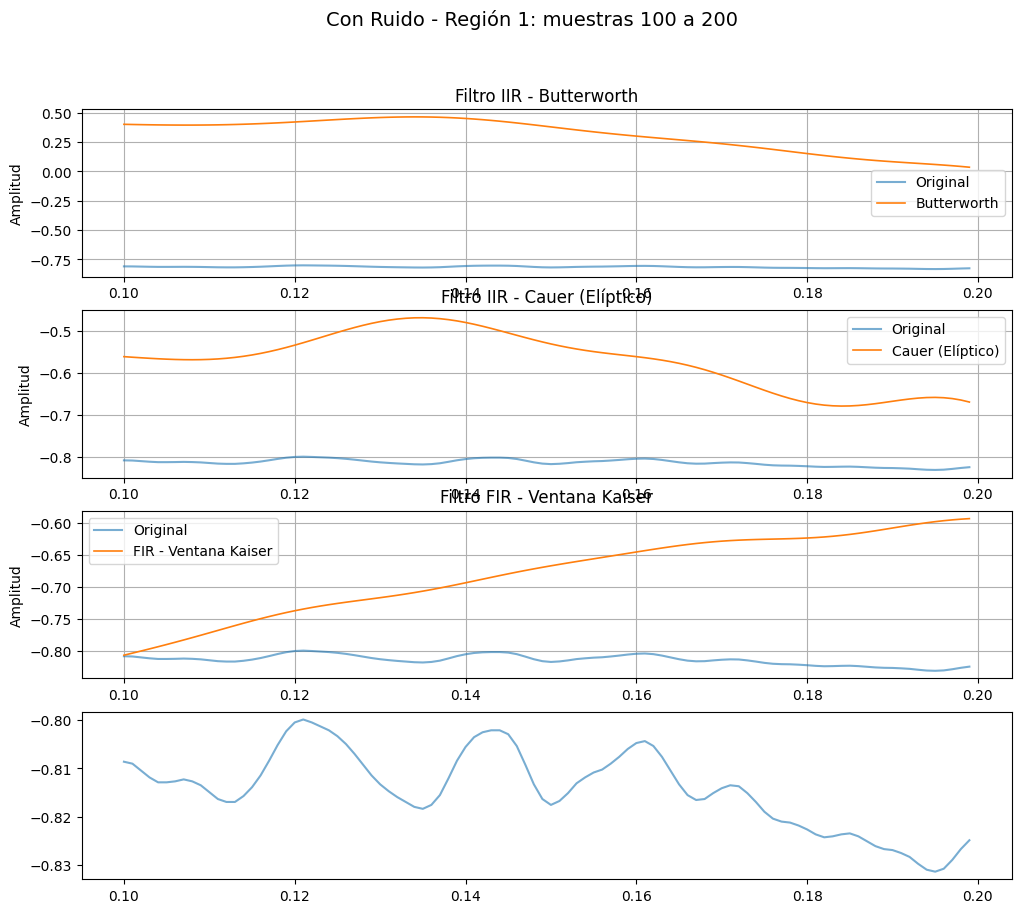

In [74]:
#%% Análisis de regiones de interés con señales filtradas

cant_muestras = len(ecg_one_lead)

# Duración total en segundos
dur_total = cant_muestras / fs_ecg

# Definir regiones con ruido (en muestras) dentro del rango válido
regs_ruido = (
    [100, 200],   # ejemplo: muestras 100 a 200 (0.1s a 0.2s)
    [300, 400],   # ejemplo: muestras 300 a 400 (0.3s a 0.4s)
)

# Definir regiones sin ruido (en segundos, convertido a muestras)
regs_sin_ruido = (
    np.array([0.1, 0.2]) * fs_ecg,   # 0.1 a 0.2 segundos
    np.array([0.4, 0.5]) * fs_ecg,   # 0.4 a 0.5 segundos
    np.array([0.5, 0.6]) * fs_ecg,   # 0.5 a 0.6 segundos
)

regiones = [("Con Ruido", regs_ruido), ("Sin Ruido", regs_sin_ruido)]

min_len = 50  # mínimo largo de región en muestras para graficar

for tipo_region, lista_regiones in regiones:
    for i, reg in enumerate(lista_regiones):
        reg = np.array(reg, dtype=int)
        start_idx, end_idx = reg[0], reg[1]

        # Verifico si la región está dentro de la señal y tiene un tamaño mínimo
        if start_idx < 0 or end_idx > cant_muestras or (end_idx - start_idx) < min_len:
            print(f"Región inválida para {tipo_region} - Región {i+1}, la salto.")
            continue

        zoom_region = np.arange(start_idx, end_idx)
        t_zoom = t_total[zoom_region]

        plt.figure(figsize=(12, 10))
        plt.suptitle(f'{tipo_region} - Región {i+1}: muestras {start_idx} a {end_idx}', fontsize=14)

        plt.subplot(4, 1, 1)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrada_butter[zoom_region], label='Butterworth', linewidth=1.2)
        plt.title('Filtro IIR - Butterworth')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrada_ellip[zoom_region], label='Cauer (Elíptico)', linewidth=1.2)
        plt.title('Filtro IIR - Cauer (Elíptico)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrado_kaiser[zoom_region], label='FIR - Ventana Kaiser', linewidth=1.2)
        plt.title('Filtro FIR - Ventana Kaiser')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrado_ls[zoom_region], label='FIR - Mínimos Cuadrados', linewidth=1.2)
        plt.title('Filtro FIR - Mínimos Cuadrados')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

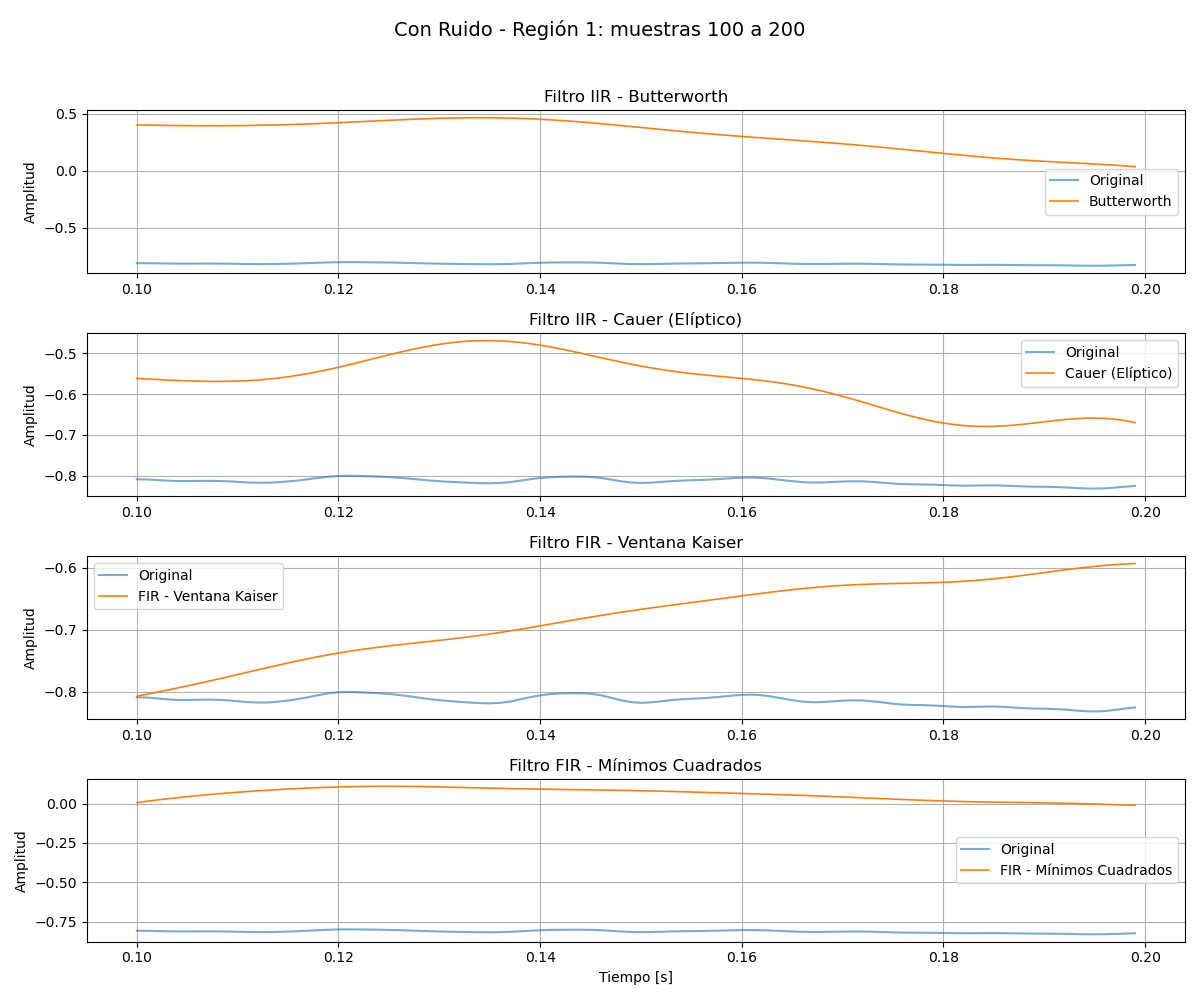

In [7]:
from IPython.display import Image
Image("Región 1.PNG", width=1000, height=600)


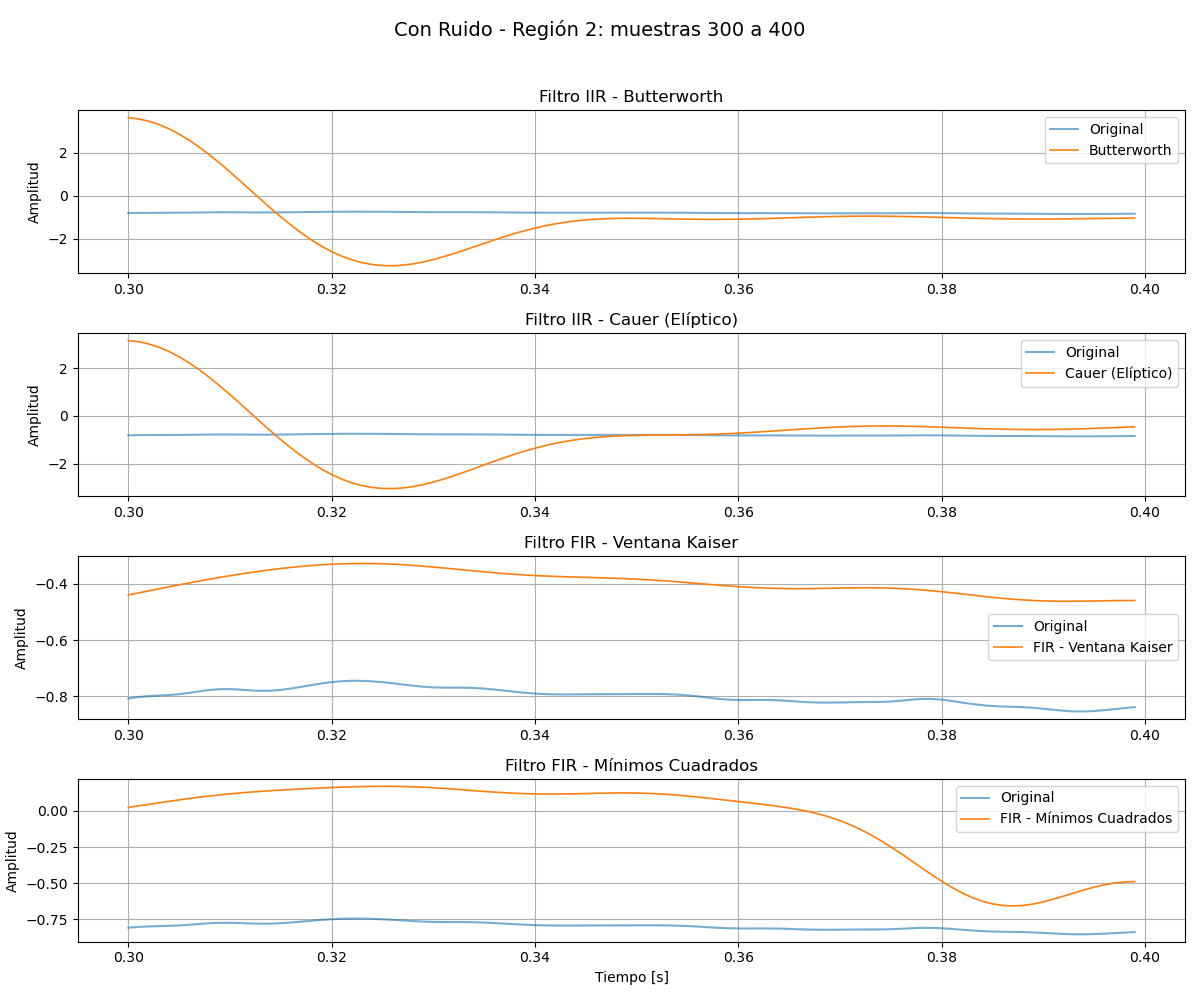

In [8]:

from IPython.display import Image
Image("Región 2.PNG", width=1000, height=600)


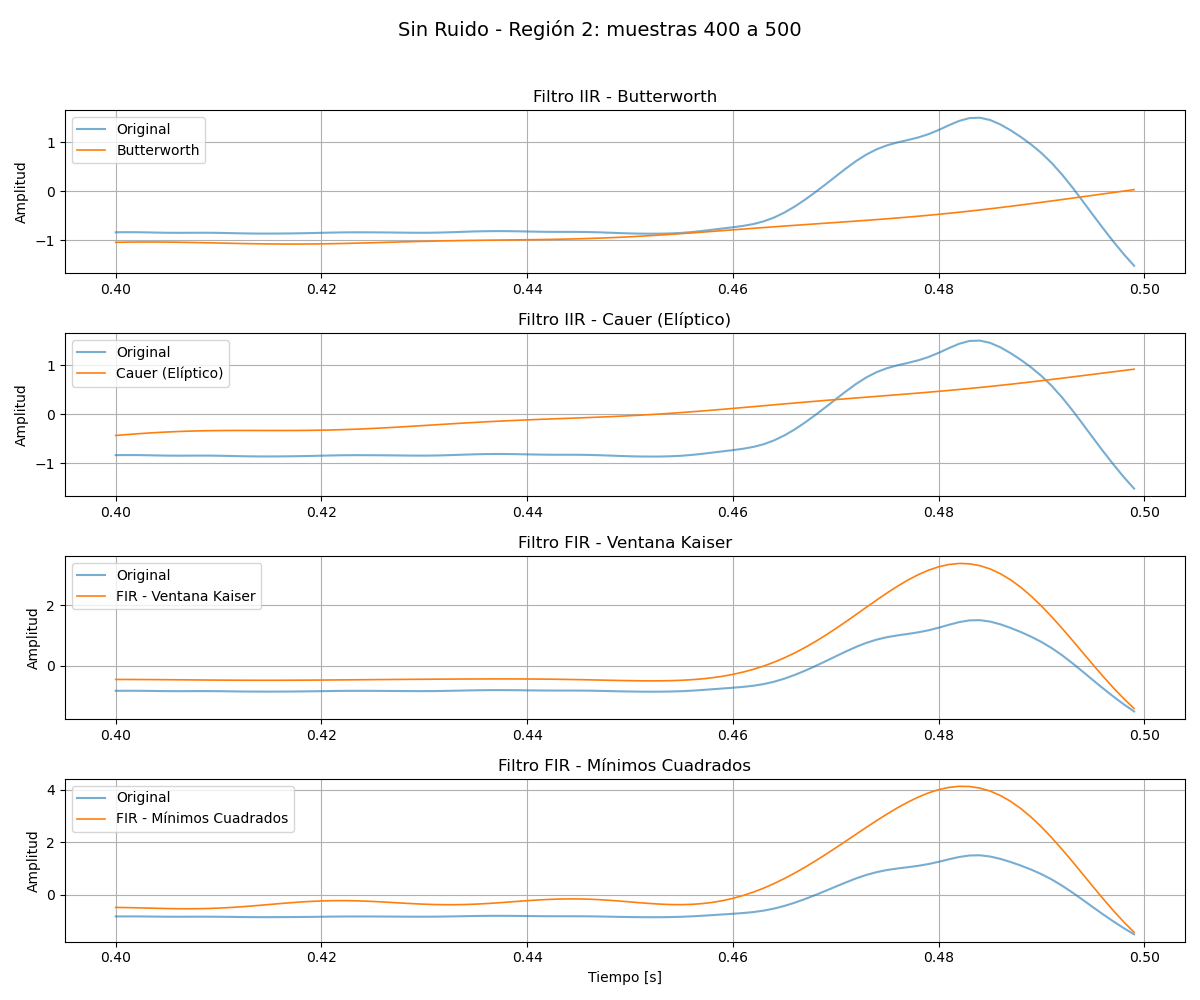

In [9]:

from IPython.display import Image
Image("Región 2.2.PNG", width=1000, height=600)



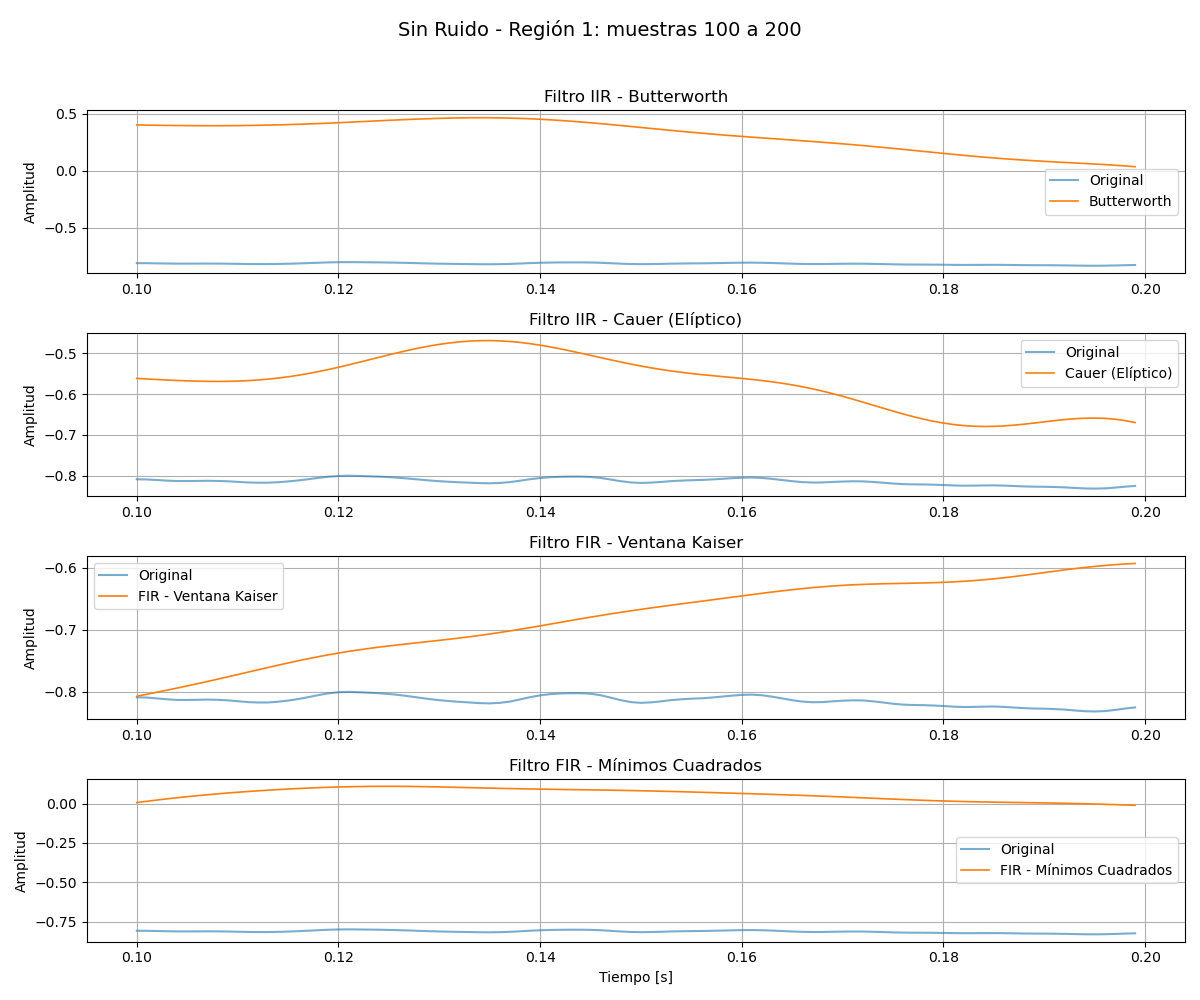

In [10]:
from IPython.display import Image
Image("Región 3.PNG", width=1000, height=600)



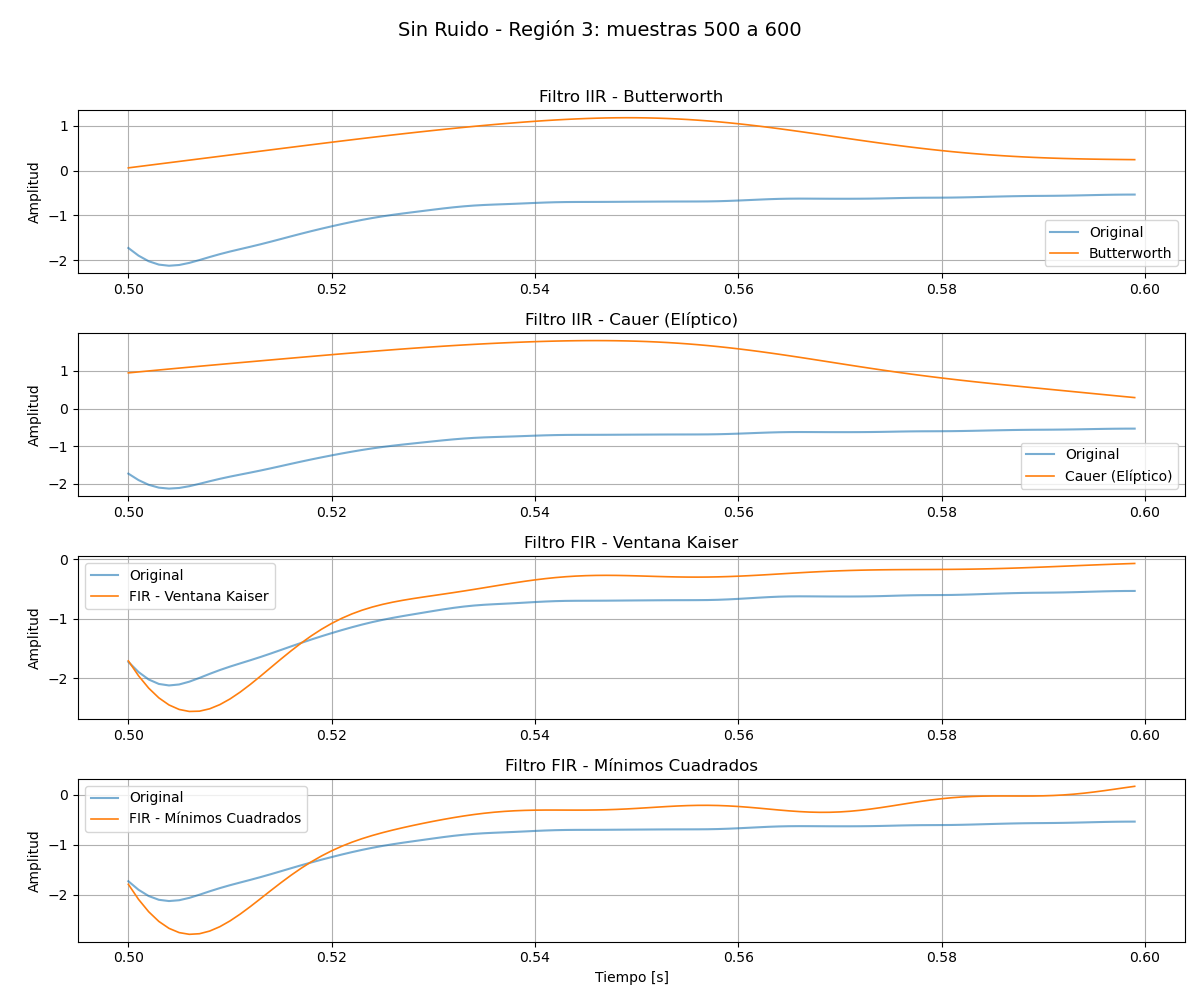

In [12]:
from IPython.display import Image
Image("Región 3.2.PNG", width=1000, height=600)

# Análisis del rendimiento de los filtros diseñados


A continuación se analiza el comportamiento de los filtros en términos de capacidad de filtrado y preservación de la morfología de la señal ECG, considerando distintos segmentos fisiológicos y regiones con y sin interferencias.

## 1. Segmento QRS (latido aislado)
El complejo QRS es el componente de mayor energía y contiene las frecuencias más altas del ECG. Por eso, es particularmente sensible al rizado en banda de paso y a distorsiones en la pendiente.

- Butterworth: fue el que mejor conservó la forma del QRS. Las pendientes ascendentes y descendentes se mantienen suaves, sin introducción de rizado ni pérdida de amplitud. Esto se debe a que este filtro tiene una respuesta monótona en banda de paso, ideal para preservar la morfología.

- Cauer (Elíptico): aunque logra una atenuación más selectiva, su mayor rizado en banda de paso genera pequeñas ondulaciones en el QRS. Esto se traduce en distociones de alta frecuencia justo donde más precisión se necesita. Es eficaz contra el ruido, pero menos delicado.

- FIR - Ventana Kaiser: mantiene la forma general del QRS con buena alineación temporal (fase lineal), pero la respuesta más abrupta de la ventana produce un QRS más picudo y menos suave que los IIR. La ventaja es que no introduce distorsión de fase.

- FIR - Mínimos Cuadrados (LS): es el que mostró mayor distorsión. Las pendientes del QRS aparecen deformadas y con oscilaciones alrededor del trazo de la señl original, resultado de una respuesta más fuerte en las transiciones y menor control del rizado. Requiere un orden mucho mayor para obtener resultados similares a un IIR.

Conclusión: El filtro Butterworth es el que mejor funcionaen este segmento, por su suavidad y precisión en la conservación morfológica.

## 2.  Segmento completo P - QRS - T (latido completo)
Este análisis incluye las ondas de baja amplitud P y T, así como el segmento isoeléctrico. Aquí el objetivo es evitar tanto la atenuación excesiva como las distorsiones temporales.

- Butterworth: las tres ondas son claramente distinguibles, con trazos suaves y sin distoción. La línea base se mantiene estable. 

- Cauer (Elíptico): la onda P muestra un leve rizado, y la T presenta oscilaciones. Esto es característico del rizado de los filtros IIR más selectivos. Aunque el ruido está bien controlado, la morfología más delicada se ve afectada.

- FIR - Ventana Kaiser: muy buen desempeño general. Gracias a su fase lineal, todas las ondas mantienen su posición temporal relativa. Las pendientes son algo más abruptas, pero la morfología es clara. 

- FIR - Mínimos Cuadrados: logra preservar las tres ondas, pero con mayor atenuación en las componentes de baja energía. Esto provoca que las ondas P y T se vean más planas, y el nivel isoeléctrico presente ondulaciones. Esto es consistente con su menor control de la forma en frecuencias bajas.

Conclusión: En este segmento, el FIR-Kaiser se destaca por su fidelidad temporal y buena conservación de la morfología completa, aunque el Butterworth también ofrece un desempeño muy bueno.

## 3. Regiones con ruido 
Estas regiones contienen fuertes componentes interferentes, como ruido muscular o desplazamientos de línea base.

- Butterworth: excelente supresión de alta y baja frecuencia. La señal se mantiene estable con trazos suaves.
- Cauer: es el más efectivo sacando interferencias gracias a su mayor selectividad, pero eso trae como consecuencia un rizado más visible, sobre todo en las zonas más planas.
- FIR-Kaiser: buena reducción del ruido, aunque requiere más muestras para estabilizarse por su orden elevado.
- FIR-LS: atenúa algo de ruido, pero es el que deja pasar más distorción. Las transiciones no son tan nítidas.


## 4. Regiones sin ruido 
Estas regiones son útiles para verificar si el filtro distorsiona innecesariamente la señal.

- Butterworth: mantiene la morfología con trazos suaves y nivel isoeléctrico constante.  No mete oscilaciones ni desfases.
- Cauer: aunque no distorsiona la señal de forma drástica, el rizado que tiene puede hacer que ciertas partes planas no se vean tan limpias, lo que puede confundir al analizar.
- FIR-Kaiser: probablemente el mejor en esta parte. Gracias a su fase lineal y buena definición, conserva la morfología, la amplitud y el tiempo de las ondas sin agregar información.
- FIR-LS: conserva la señal sin distorsiones visibles,  pero se nota que baja un poco la amplitud en las ondas más chiquitas.




# Conclusión

La tarea me permitió comparar distintos enfoques de filtrado digital para el procesamiento de señales ECG, destacando las fortalezas y limitaciones de los filtros IIR y FIR en contextos reales con interferencias fisiológicas y de entorno.

Los filtros IIR, como Butterworth y Cauer, demostraron ser altamente eficientes para aplicaciones donde se requiere una fuerte atenuación con bajo costo computacional. Butterworth, en particular, ofreció un muy buen equilibrio entre supresión de ruido y conservación de la morfología, gracias a su transición suave y respuesta en frecuencia estable. Cauer, por su parte, resultó más selectivo y eficaz en ambientes muy ruidosos, aunque con el costo de introducir mayor rizado en banda de paso, lo que puede distorsionar la morfología de las ondas más suaves como la P y la T.

Por otro lado, los filtros FIR, especialmente el diseñado con ventana de Kaiser, ofrecieron la ventaja fundamental de una fase lineal constante, preservando la alineación temporal de las ondas ECG y evitando el desfasaje temporal típico de los filtros IIR. Esta característica, sin embargo, implica un mayor orden de filtro y, por ende, una mayor carga computacional. Además, dado que la señal ECG presenta un amplio rango de frecuencias importantes, resulta difícil diseñar un filtro FIR único que satisfaga todos los requisitos de atenuación y transición. En este sentido, y siguiendo un comentario del docente sobre filtros FIR pasa banda, intenté implementar un filtro en cascada combinando un pasa bajos y un pasa altos, de modo que la respuesta total fuera la convolución de ambas respuestas. Sin embargo, la respuesta resultante de la convolución me daba cero, y dado que el código, de la convolución de ambos filtros, no fue visto en clase, opte por diseñar directamente un filtro pasa banda FIR.

Para mi sorpresa, el filtro FIR diseñado mediante el método de mínimos cuadrados (LS), pese a ser conceptualmente más robusto para aproximar una respuesta ideal, mostró un desempeño inferior al método de ventanas en este contexto. Al analizar el efecto del orden 𝑁 en el diseño por mínimos cuadrados, se observó que para valores bajos (por ejemplo, N=50) la señal filtrada se asemeja mucho a la original, aunque con limitada capacidad para aproximar la plantilla deseada. Al aumentar 𝑁 (ej. 𝑁=150), el filtro ajusta mejor la respuesta, manteniendo similitud con la señal original. Sin embargo, con órdenes aún mayores (ej. 𝑁=207 y superiores), el filtro optimiza globalmente la respuesta, pero comienza a “cruzar” parcialmente la plantilla entre puntos específicos.

Este fenómeno ocurrio especialmente en la zona de bajas frecuencias y puede atribuirse a la naturaleza FIR del filtro, que dificulta la implementación de transiciones abruptas o muy ajustadas en un rango de frecuencia tan amplio como el del ECG. Por ello, el filtro debe comprometerse entre la fidelidad en toda la banda, generando estos cruces o desviaciones locales en la plantilla para mantener un ajuste global aceptable.

La optimización LS minimiza el error cuadrático total en toda la banda, permitiendo desviaciones locales para mejorar el ajuste global. Esto provoca que la señal filtrada se aleje más de la original. Este “cruce parcial” es un compromiso que hice consciente: priorice el ajuste global y cumplimiento de especificaciones, aceptando desviaciones puntuales, para evitar un sobreajuste que degrade la respuesta general.

En contraste, el método de ventanas, aunque menos óptimo, produce respuestas más suaves y controladas al limitar las oscilaciones y picos abruptos, favoreciendo una mejor preservación morfológica en la señal ECG.

En lo personal me costó bastante más diseñar los filtros FIR que los IIR. Creo que tiene que ver con la naturaleza de la señal y también porque no usé un filtro en cascada, que Mariano comentó que suele ayudar bastante en ese tipo de casos. Definir los parámetros para los FIR se me hizo mucho más complicado, y siento que son filtros más “laxos” con respecto a la plantilla, no tan estrictos como los IIR.

